# CS417L - Open Ended Lab
**Atesam Abdullah 2021114 BSAI**

In [29]:
%%writefile oel.cu

#include <stdio.h>
#include <cuda_runtime.h>
#include <opencv2/opencv.hpp>
#include <chrono>

using namespace cv;
using namespace std;

// CUDA kernel for brightness adjustment
__global__ void adjustBrightnessRGB(unsigned char *input, unsigned char *output, int width, int height, int channels, int brightnessFactor) {
    int x = blockIdx.x * blockDim.x + threadIdx.x;
    int y = blockIdx.y * blockDim.y + threadIdx.y;

    if (x < width && y < height) {
        int idx = (y * width + x) * channels;
        for (int c = 0; c < channels; ++c) {
            int pixel = input[idx + c] + brightnessFactor;
            output[idx + c] = min(max(pixel, 0), 255); // Clamp pixel values between 0 and 255
        }
    }
}

// Brightness adjustment on CPU
void adjustBrightnessCPURGB(const Mat &input, Mat &output, int brightnessFactor) {
    for (int y = 0; y < input.rows; ++y) {
        for (int x = 0; x < input.cols; ++x) {
            for (int c = 0; c < input.channels(); ++c) {
                // Read pixel value
                int pixel = input.at<Vec3b>(y, x)[c] + brightnessFactor;
                // Clamp value and update output image
                output.at<Vec3b>(y, x)[c] = min(max(pixel, 0), 255);
            }
        }
    }
}

int main(int argc, char **argv) {
    if (argc != 4) {
        printf("Usage: %s <input_image> <output_image> <brightness_factor>\n", argv[0]);
        return -1;
    }

    // Load input image in RGB format
    Mat inputImage = imread(argv[1], IMREAD_COLOR);
    if (inputImage.empty()) {
        printf("Error: Could not load image %s\n", argv[1]);
        return -1;
    }

    int brightnessFactor = atoi(argv[3]);
    Mat cpuOutputImage = Mat::zeros(inputImage.size(), inputImage.type());
    Mat gpuOutputImage = Mat::zeros(inputImage.size(), inputImage.type());

    int width = inputImage.cols;
    int height = inputImage.rows;
    int channels = inputImage.channels();

    // CPU Brightness Adjustment
    auto cpuStart = chrono::high_resolution_clock::now();
    adjustBrightnessCPURGB(inputImage, cpuOutputImage, brightnessFactor);
    auto cpuEnd = chrono::high_resolution_clock::now();
    double cpuDuration = chrono::duration<double, milli>(cpuEnd - cpuStart).count();

    // GPU Brightness Adjustment
    unsigned char *d_input, *d_output;
    size_t imageSize = width * height * channels * sizeof(unsigned char);

    cudaMalloc(&d_input, imageSize);
    cudaMalloc(&d_output, imageSize);

    cudaMemcpy(d_input, inputImage.ptr(), imageSize, cudaMemcpyHostToDevice);

    dim3 blockSize(16, 16);
    dim3 gridSize((width + blockSize.x - 1) / blockSize.x,
                  (height + blockSize.y - 1) / blockSize.y);

    auto gpuStart = chrono::high_resolution_clock::now();
    adjustBrightnessRGB<<<gridSize, blockSize>>>(d_input, d_output, width, height, channels, brightnessFactor);
    cudaDeviceSynchronize();
    auto gpuEnd = chrono::high_resolution_clock::now();

    cudaMemcpy(gpuOutputImage.ptr(), d_output, imageSize, cudaMemcpyDeviceToHost);

    double gpuDuration = chrono::duration<double, milli>(gpuEnd - gpuStart).count();

    // Free GPU memory
    cudaFree(d_input);
    cudaFree(d_output);

    // Save CPU and GPU output images
    imwrite("cpu_" + string(argv[2]), cpuOutputImage);
    imwrite("gpu_" + string(argv[2]), gpuOutputImage);

    // Output performance metrics
    printf("Performance Metrics:\n");
    printf("CPU Time: %.2f ms\n", cpuDuration);
    printf("GPU Time: %.2f ms\n", gpuDuration);

    return 0;
}

Overwriting oel.cu


In [30]:
!nvcc oel.cu -o a `pkg-config --cflags --libs opencv4`  -diag-suppress 611
!./a 512.jpg 512.jpg 100
!echo
!./a 1024.jpg 1024.jpg 100
!echo
!./a 2048.jpg 2048.jpg 100
!echo
!./a 4096.jpg 4096.jpg 100
!echo
!./a 8192.jpg 8192.jpg 100

Performance Metrics:
CPU Time: 27.64 ms
GPU Time: 0.20 ms

Performance Metrics:
CPU Time: 94.04 ms
GPU Time: 0.26 ms

Performance Metrics:
CPU Time: 235.92 ms
GPU Time: 0.46 ms

Performance Metrics:
CPU Time: 1505.08 ms
GPU Time: 1.32 ms

Performance Metrics:
CPU Time: 3553.28 ms
GPU Time: 4.50 ms


In [28]:
! rm *pu_*

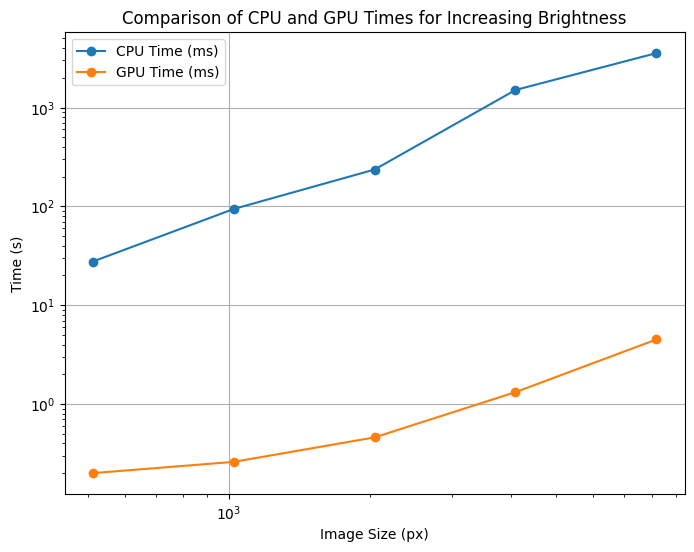

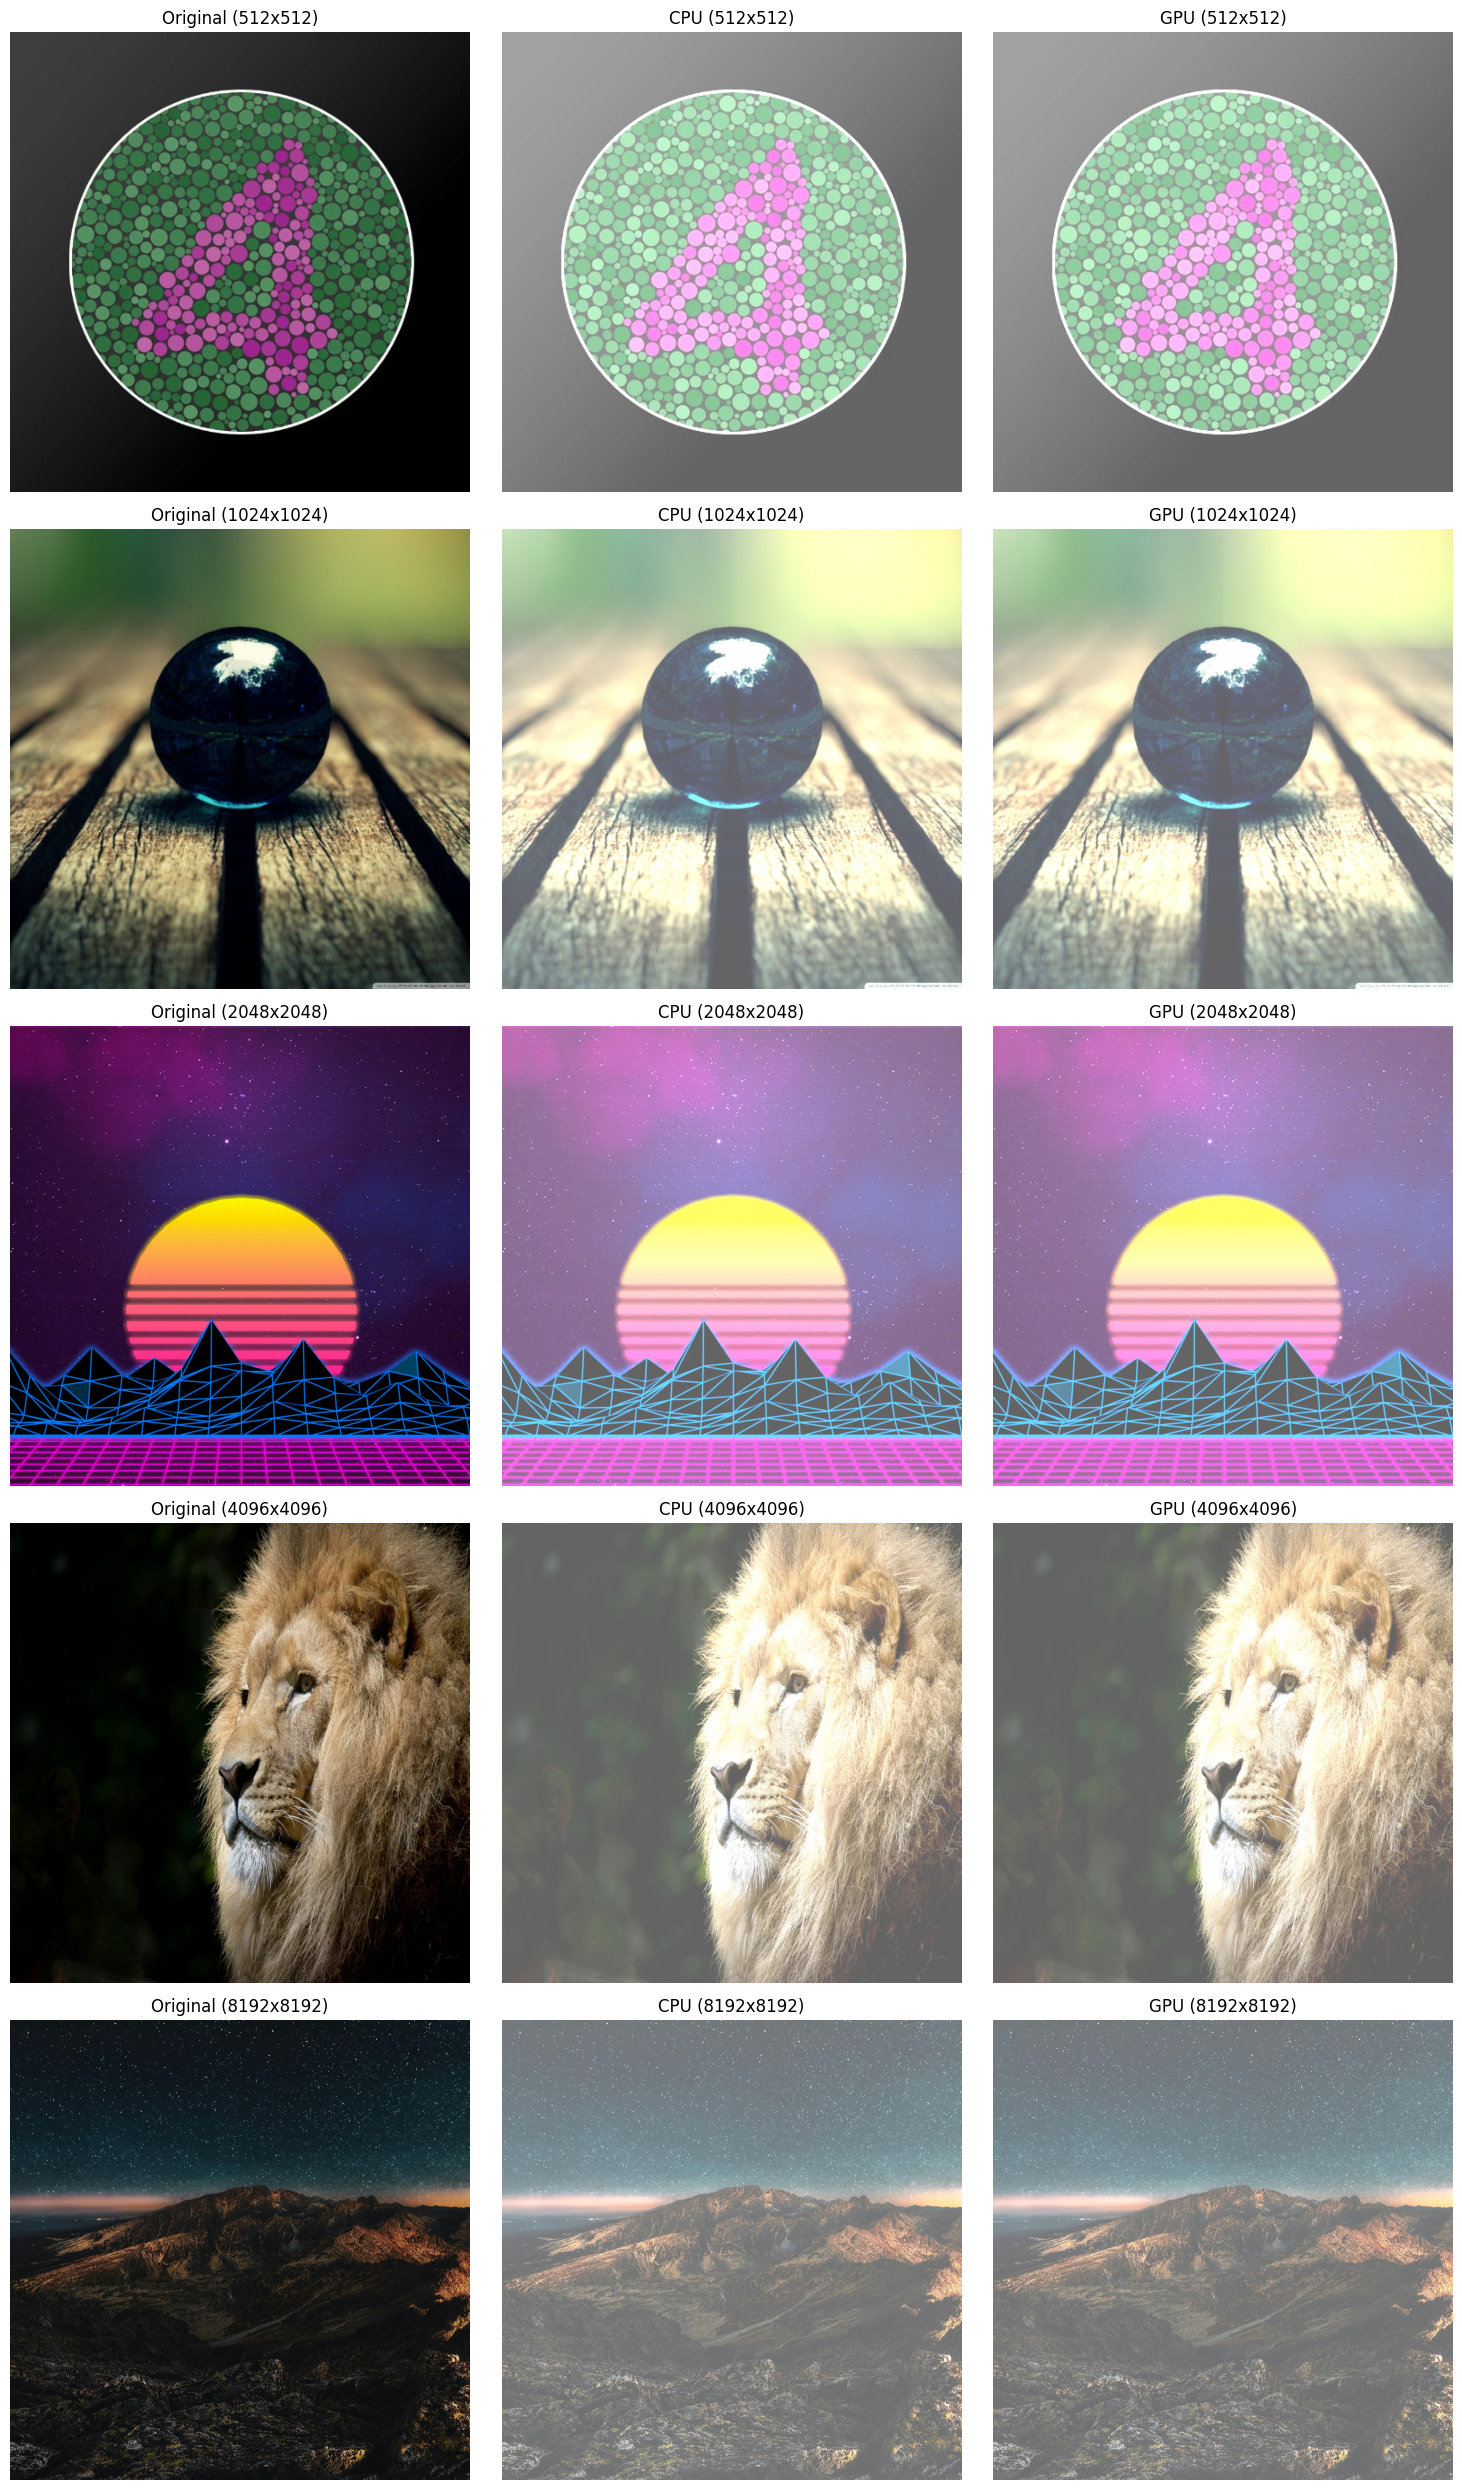

In [32]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

# Define the image sizes
image_sizes = [512, 1024, 2048, 4096, 8192]

# Function to load and display images
def display_images(image_sizes):
    fig, axes = plt.subplots(len(image_sizes), 3, figsize=(15, 5 * len(image_sizes)))

    for i, size in enumerate(image_sizes):
        # Image paths
        og_img_path = f'{size}.jpg'
        cpu_img_path = f'cpu_{size}.jpg'
        gpu_img_path = f'gpu_{size}.jpg'

        # Load the images
        og_img = mpimg.imread(og_img_path)
        cpu_img = mpimg.imread(cpu_img_path)
        gpu_img = mpimg.imread(gpu_img_path)

        # Display the images in the appropriate subplots
        axes[i, 0].imshow(og_img)
        axes[i, 0].set_title(f'Original ({size}x{size})')
        axes[i, 0].axis('off')

        axes[i, 1].imshow(cpu_img)
        axes[i, 1].set_title(f'CPU ({size}x{size})')
        axes[i, 1].axis('off')

        axes[i, 2].imshow(gpu_img)
        axes[i, 2].set_title(f'GPU ({size}x{size})')
        axes[i, 2].axis('off')

    plt.tight_layout()
    plt.show()

# Example CPU and GPU times (replace with your actual data)
cpu_times = [27.64, 94.04, 235.92,1505.08, 3553.28]  # Sample CPU times for each image size
gpu_times = [0.20, 0.26, 0.46, 1.32, 4.50]  # Sample GPU times for each image size

# Plot the CPU and GPU times
plt.figure(figsize=(8, 6))
plt.plot(image_sizes, cpu_times, label='CPU Time (ms)', marker='o')
plt.plot(image_sizes, gpu_times, label='GPU Time (ms)', marker='o')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Image Size (px)')
plt.ylabel('Time (s)')
plt.title('Comparison of CPU and GPU Times for Increasing Brightness')
plt.legend()
plt.grid(True)
plt.show()

# Call the function to display images
display_images(image_sizes)